In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import SGD

import numpy as np
import math

import cv2
import matplotlib.pyplot as plt

## Load KITTI dataset

In [2]:
# dataset structure: # https://www.tensorflow.org/datasets/catalog/kitti
# classes: https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/kitti/kitti_dataset_builder.py
def load_kitti_dataset():
    dataset = tfds.load('kitti')   # es. split='train[:5%]' prende solo l'ultimo 5% del dataset
    return dataset

In [3]:
dataset = load_kitti_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kitti/incomplete.CG7ABW_3.3.0/kitti-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kitti/incomplete.CG7ABW_3.3.0/kitti-validation.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kitti/incomplete.CG7ABW_3.3.0/kitti-test.tfrecord*...:   0%|          | 0/…

Dataset kitti downloaded and prepared to /root/tensorflow_datasets/kitti/3.3.0. Subsequent calls will reuse this data.


In [ ]:
training_set = dataset['train']
test_set = dataset['test']
validation_set = dataset['validation']

#### Show an example of images in the dataset

In [ ]:
for example in training_set.take(1):
    print(example)
    print("Label: ", example["objects"]["type"].numpy()[0])   # get the label

{'image': <tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
array([[[186,  65,  46],
        [156,  49,  19],
        [ 51,  39,  17],
        ...,
        [  9,   9,   5],
        [  9,  12,   6],
        [ 10,  11,   5]],

       [[198, 111,  36],
        [203,  88,  37],
        [ 84,  57,  37],
        ...,
        [  9,   9,   6],
        [ 10,   9,   6],
        [ 11,  10,   6]],

       [[ 39,  80,  35],
        [ 54,  88,  39],
        [ 40,  60,  45],
        ...,
        [  8,   8,   7],
        [  9,   9,   6],
        [ 12,  11,   7]],

       ...,

       [[ 36,  65,  42],
        [ 34,  61,  37],
        [ 31,  49,  35],
        ...,
        [ 73, 142, 102],
        [117, 151, 117],
        [153, 134,  93]],

       [[ 30,  60,  36],
        [ 32,  49,  31],
        [ 31,  42,  29],
        ...,
        [ 69, 112,  56],
        [108, 158,  64],
        [147, 168,  70]],

       [[ 46,  50,  34],
        [ 48,  52,  31],
        [ 34,  50,  29],
        ...,
        [ 

In [ ]:
def draw_3d_box(image, dimensions, location, orientation, K):
    # unpack dimensions (height, width, length)
    h, w, l = dimensions

    # compute the corners of the bounding box in object coordinates
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
    corners = np.array([x_corners, y_corners, z_corners])

    # rotation matrix around the Y-axis
    R_y = np.array([[ np.cos(orientation), 0, np.sin(orientation)],
                    [0, 1, 0],
                    [-np.sin(orientation), 0, np.cos(orientation)]])

    # rotate and translate the corners to camera coordinates
    corners_3d = (R_y @ corners).T + location

    # project the 3D corners onto the 2D image plane
    corners_2d = []
    for corner in corners_3d:
        corner_homogeneous = np.append(corner, 1)
        projected = K @ corner_homogeneous[:3]
        projected /= projected[2]  # normalize by depth
        corners_2d.append(projected[:2])

    corners_2d = np.array(corners_2d, dtype=np.int32)

    # define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
    ]

    for start, end in edges:
        pt1 = tuple(corners_2d[start])
        pt2 = tuple(corners_2d[end])
        cv2.line(image, pt1, pt2, color=(0, 255, 0), thickness=2)

    return image

Label:  0
Dimension:  [1.48 1.87 4.42]
Location:  [-3.27  1.89 28.56]
Alpha:  1.7
Rotation Y:  1.59


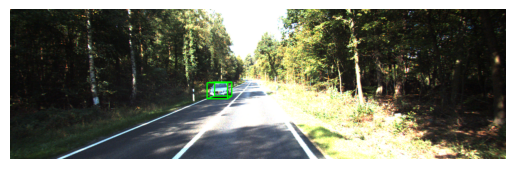

In [ ]:
# camera intrinsic matrix
K = np.array([[721.5377, 0, 609.5593],
              [0, 721.5377, 172.854],
              [0, 0, 1]])

for example in training_set.take(1):
    image = example["image"].numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = example["objects"]["type"].numpy()[0]
    dimensions = example["objects"]["dimensions"].numpy()[0]
    location = example["objects"]["location"].numpy()[0]
    alpha = example["objects"]["alpha"].numpy()[0]
    orientation = example["objects"]["rotation_y"].numpy()[0]

    print("Label: ", label)
    print("Dimension: ", dimensions)
    print("Location: ", location)
    print("Alpha: ", alpha)
    print("Rotation Y: ", orientation)

    # draw the 3D bounding box on the image
    image_with_bbox = draw_3d_box(image.copy(), dimensions, location, orientation, K)
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



## Create the model architecture


*   VGG16 model for feature extraction
*   2 FC layers for dimension estimation
*   2 FC layers for location estimation
*   2 FC layers + 2D norm for orientation estimation
*   2 FC layers for class estimation






In [ ]:
# model hyperparameters
batch_size = 32
num_bin = 2
input_shape = (224, 224, 3)   # (H, W, num_channels)
learning_rate = 0.0001
epochs = 50

In [ ]:
def multibin_model(input_shape=(224, 224, 3), num_bin=2):
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16.trainable = False

    # model for feature extraction: based on pre-trained VGG, as mentioned in the paper
    feature_model = tf.keras.Sequential([
        layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
        vgg16,

        ],
        name="feature_model")

    # construction of the 3D box module, made up of 3 modules: estimation of dimensions, orientations and confidences
    # model for estimation of dimensions: 2 FC layers
    dimension_model = models.Sequential([
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(3, name='dim_output')  # dimensions: dx, dy, dz
        ],
        name="dimension_model")

    # model for estimation of orientations: 2 FC layers + L2 Norm
    orientation_model = models.Sequential([
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_bin*2, activation='linear'),  # rotation y axis
        layers.Lambda(lambda x: tf.math.l2_normalize(x), name='orient_output')
        ],
        name="orientation_model")

    # model for computing confidences: 2 FC layers
    confidence_model = models.Sequential([
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_bin, activation='softmax', name='conf_output')
        ],
        name="confidence_model")


    # create connections between the three models to create the overall architecture
    # define input tensor
    input_tensor = tf.keras.Input(shape=input_shape)

    # get feature output by calling feature_model with input_tensor
    feature_output = feature_model(input_tensor)
    dimension_output = dimension_model(feature_output)
    orientation_output = orientation_model(feature_output)
    confidence_output = confidence_model(feature_output)

    model = models.Model(inputs=input_tensor,
                         outputs={'dimension_model':dimension_output, 'orientation_model':orientation_output, 'confidence_model':confidence_output})

    print(model.summary())
    return model

## Model training

### Data generator

In [ ]:
print("Samples in training set:", len(training_set))
print("Samples in validation set:", len(validation_set))
print("Samples in test set:", len(test_set))

Samples in training set: 6347
Samples in validation set: 423
Samples in test set: 711


In [ ]:
# Data preparation
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image

def prepare_data_batch(data_batch, num_bin):
    images, dimensions, orientations, confidences = [], [], [], []

    for sample in data_batch:
        image = preprocess_image(sample['image'])
        images.append(image)

        dimensions.append(sample['objects']['dimensions'][0])

        rotation = sample['objects']['rotation_y'][0].numpy()
        orientation = np.zeros((num_bin, 2))
        confidence = np.zeros(num_bin)

        bin_size = 2 * np.pi / num_bin
        bin_index = int((rotation + np.pi) / bin_size) % num_bin

        confidence[bin_index] = 1
        angle_in_bin = rotation - (bin_index * bin_size - np.pi)
        orientation[bin_index] = [np.cos(angle_in_bin), np.sin(angle_in_bin)]

        orientations.append(orientation.flatten())
        confidences.append(confidence)

    return (tf.stack(images),
            tf.convert_to_tensor(dimensions, dtype=tf.float32),
            tf.convert_to_tensor(orientations, dtype=tf.float32),
            tf.convert_to_tensor(confidences, dtype=tf.float32))

def data_generator(dataset, batch_size=32, num_bin=2):
    batch = []
    for sample in dataset:
        batch.append(sample)
        if len(batch) == batch_size:
            images, dimensions, orientations, confidences = prepare_data_batch(batch, num_bin)
            yield images, {'dimension_model': dimensions,
                           'orientation_model': orientations,
                           'confidence_model': confidences}
            batch = []

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(training_set, batch_size=batch_size, num_bin=num_bin),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
        {
            'dimension_model': tf.TensorSpec(shape=(batch_size, 3), dtype=tf.float32),
            'orientation_model': tf.TensorSpec(shape=(batch_size, 2 * num_bin), dtype=tf.float32),
            'confidence_model': tf.TensorSpec(shape=(batch_size, num_bin), dtype=tf.float32)
        }
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(validation_set, batch_size=batch_size, num_bin=num_bin),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
        {
            'dimension_model': tf.TensorSpec(shape=(batch_size, 3), dtype=tf.float32),
            'orientation_model': tf.TensorSpec(shape=(batch_size, 2 * num_bin), dtype=tf.float32),
            'confidence_model': tf.TensorSpec(shape=(batch_size, num_bin), dtype=tf.float32)
        }
    )
)

train_dataset = train_dataset.repeat().prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().prefetch(tf.data.experimental.AUTOTUNE)

### Model training

In [ ]:
def localization_loss(loc_true, loc_pred):
    num_bins = loc_pred.shape[1] // 2
    loc_pred = tf.reshape(loc_pred, [-1, num_bins, 2])  # reshape for bins and [cos, sin]
    loc_pred_normalized = tf.math.l2_normalize(loc_pred, axis=2)

    loc_true = tf.reshape(loc_true, [-1, num_bins, 2])
    loc_true_normalized = tf.math.l2_normalize(loc_true, axis=2)

    cos_similarity = tf.reduce_sum(loc_pred_normalized * loc_true_normalized, axis=2)
    loc_loss = -tf.reduce_mean(cos_similarity)
    return loc_loss

def confidence_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

def orientation_loss(y_true, y_pred):
    num_bins = y_pred.shape[1] // 2    # number of bins
    conf_true = y_true[:, :num_bins]
    loc_true = y_true[:, num_bins:]

    conf_pred = y_pred[:, :num_bins]
    loc_pred = y_pred[:, num_bins:]

    conf_loss = confidence_loss(conf_true, conf_pred)
    loc_loss = localization_loss(loc_true, loc_pred)

    return conf_loss + 3.0 * loc_loss   # (3.0 = weights associated to the localization loss function)

In [ ]:
training_set_dimension = len(training_set)
validation_set_dimension = len(validation_set)
train_steps_per_epoch = math.floor(training_set_dimension / batch_size)
val_steps_per_epoch = math.floor(validation_set_dimension/batch_size)

model = multibin_model(input_shape=input_shape, num_bin=num_bin)

losses = {
    'dimension_model': 'mse',
    'orientation_model': orientation_loss,
    'confidence_model': confidence_loss
}

optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=losses)

history = model.fit(train_dataset,
          steps_per_epoch=train_steps_per_epoch,
          validation_data=val_dataset,
          validation_steps=val_steps_per_epoch,
          epochs=epochs
          )

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_model             │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ confidence_model          │ (None, 2)              │      6,423,298 │ feature_model[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dimension_model           │ (None, 3)              │     12,847,107 │ feature_model[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ orientation_model         │ (None, 4)              │      6,423,812 │ feature_model[0][0]    │
│ (Sequential)              │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 40,408,905 (154.15 MB)

 Trainable params: 25,694,217 (98.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 128s 616ms/step - confidence_model_loss: 1.4390 - dimension_model_loss: 11.0789 - loss: 11.2495 - orientation_model_loss: -1.2685 - val_confidence_model_loss: 1.0371 - val_dimension_model_loss: 0.5003 - val_loss: 0.0823 - val_orientation_model_loss: -1.4551
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 146s 639ms/step - confidence_model_loss: 1.1404 - dimension_model_loss: 1.7333 - loss: 1.5612 - orientation_model_loss: -1.3125 - val_confidence_model_loss: 0.7122 - val_dimension_model_loss: 0.4937 - val_loss: -0.2525 - val_orientation_model_loss: -1.4585
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 120s 608ms/step - confidence_model_loss: 1.0617 - dimension_model_loss: 1.7239 - loss: 1.4725 - orientation_model_loss: -1.3132 - val_confidence_model_loss: 0.8217 - val_dimension_model_loss: 0.4883 - val_loss: -0.1500 - val_orientation_model_loss: -1.4601
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 139s 625ms/step - confidence_model_loss: 1.0116 - dimension_mod

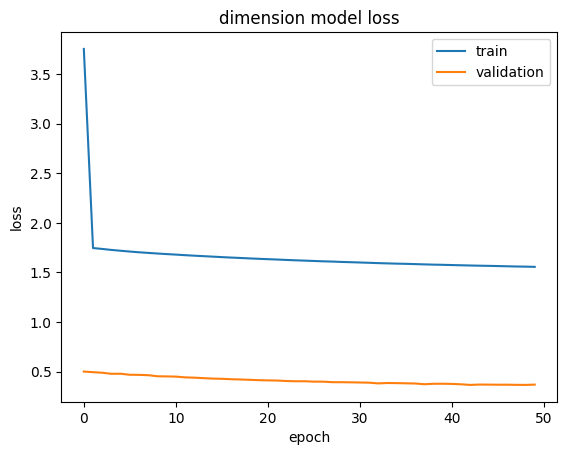

In [ ]:
plt.plot(history.history['dimension_model_loss'])
plt.plot(history.history['val_dimension_model_loss'])
plt.title('dimension model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

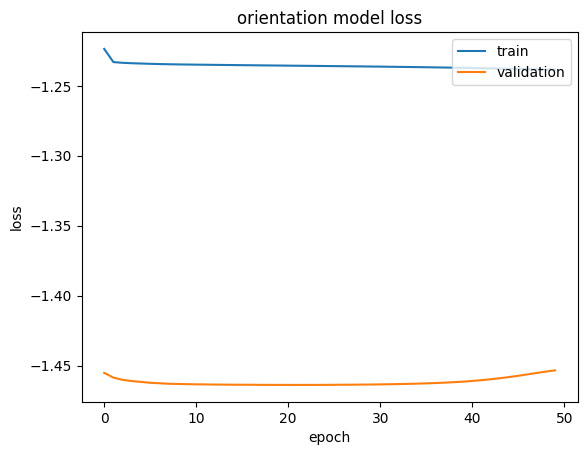

In [ ]:
plt.plot(history.history['orientation_model_loss'])
plt.plot(history.history['val_orientation_model_loss'])
plt.title('orientation model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

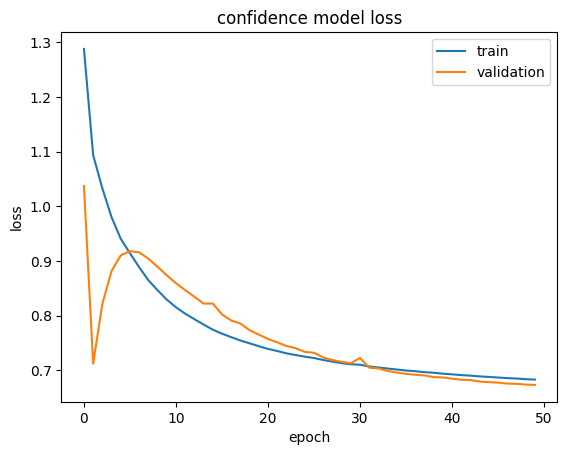

In [ ]:
plt.plot(history.history['confidence_model_loss'])
plt.plot(history.history['val_confidence_model_loss'])
plt.title('confidence model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

##Inference

In [ ]:
def calculate_rotation(orientation, active_bin, num_bin):
    bin_size = 2 * np.pi / num_bin  # bin size in radians
    bin_index = confidence  # active bin index

    cos_value = orientation[2 * bin_index]
    sin_value = orientation[2 * bin_index + 1]

    angle_in_bin = np.arctan2(sin_value, cos_value)
    rotation = angle_in_bin + (bin_index * bin_size) - np.pi
    rotation = round(rotation, 4)
    return rotation

In [ ]:
def inference(model, image):
    image = preprocess_image(image)
    prediction = model.predict(np.expand_dims(image, axis=0))
    return prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Sample 1
Dimension:  [1.6830266 1.7695861 4.307575 ]
Orientation:  [-0.11989608  0.5852069  -0.0928805   0.7965746 ]
Confidence:  1
Rotation_Y:  1.6869


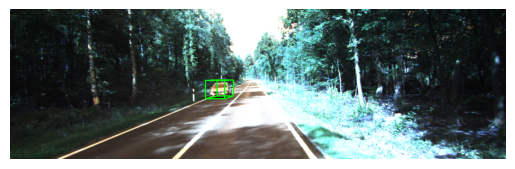


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample 2
Dimension:  [1.701799  1.5947217 4.0412474]
Orientation:  [-0.12785962  0.58777225 -0.09987422  0.79259115]
Confidence:  0
Rotation_Y:  -1.3566


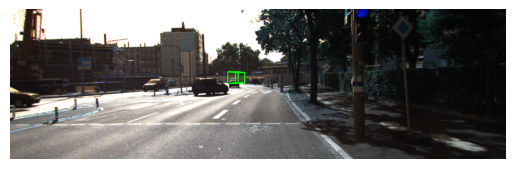


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 3
Dimension:  [1.7958707 1.9414965 4.7541614]
Orientation:  [-0.10943975  0.6058119  -0.09544656  0.78224355]
Confidence:  0
Rotation_Y:  -1.3921


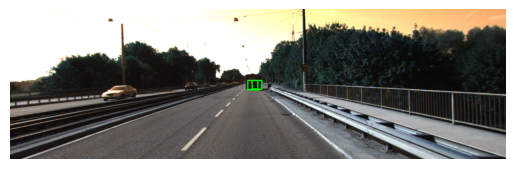


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sample 4
Dimension:  [1.678767 1.771727 4.249361]
Orientation:  [-0.12490701  0.5825297  -0.0840501   0.7987446 ]
Confidence:  0
Rotation_Y:  -1.3596


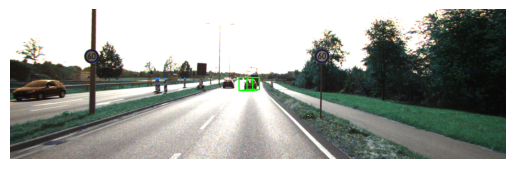


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample 5
Dimension:  [1.7230966 1.6374425 3.9592152]
Orientation:  [-0.14016046  0.5845946  -0.12376172  0.78948545]
Confidence:  0
Rotation_Y:  -1.3355


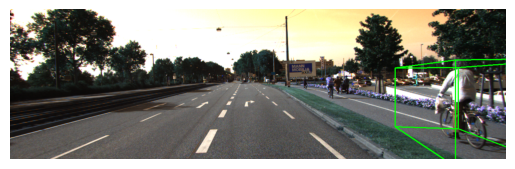

In [ ]:
# camera intrinsic matrix
K = np.array([[721.5377, 0, 609.5593],
              [0, 721.5377, 172.854],
              [0, 0, 1]])

for i, example in enumerate(training_set.take(5)):
    image = example['image']
    bbox_2d = example['objects']['bbox'].numpy()[0]
    location = example['objects']['location'].numpy()[0]

    prediction = inference(model, image)
    dimension = prediction['dimension_model'][0]
    orientation = prediction['orientation_model'][0]
    confidence = prediction['confidence_model']
    confidence = np.argmax(confidence)
    rotation = calculate_rotation(orientation, confidence, num_bin)  # rotation_y

    # print("Image shape: ", image.shape)
    print("Sample", i+1)
    print("Dimension: ", dimension)
    print("Orientation: ", orientation)
    print("Confidence: ", confidence)
    print("Rotation_Y: ", rotation)

    # draw the 3D bounding box on the image
    image_with_bbox = draw_3d_box(image.numpy().copy(), dimension, location, rotation, K)
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print()

In [ ]:
# actual values (ground_truth)
for i, example in enumerate(training_set.take(5)):
    dimension = example["objects"]["dimensions"].numpy()
    orientation = example["objects"]["rotation_y"].numpy()

    print("Sample", i+1)
    print("Dimension: ", dimension)
    print("Alpha: ", orientation)
    print()


Sample 1
Dimension:  [[1.48 1.87 4.42]]
Alpha:  [1.59]

Sample 2
Dimension:  [[1.48 1.56 3.62]
 [1.67 1.64 4.32]
 [1.5  1.62 3.88]
 [1.68 1.67 4.29]]
Alpha:  [-1.65 -1.06 -0.32  1.73]

Sample 3
Dimension:  [[ 2.85  2.63 12.34]
 [ 1.5   1.95  4.6 ]
 [ 1.84  2.04  4.33]]
Alpha:  [-1.5   1.57  1.58]

Sample 4
Dimension:  [[1.26 1.6  3.56]
 [1.37 1.63 3.57]
 [2.26 1.64 5.2 ]
 [1.45 1.53 3.5 ]]
Alpha:  [-1.6  -1.6  -1.57  1.56]

Sample 5
Dimension:  [[1.9  0.77 1.93]
 [1.8  0.52 1.75]
 [1.7  0.69 0.68]
 [1.7  0.48 0.87]
 [1.   0.5  0.77]
 [1.64 0.44 1.56]]
Alpha:  [-1.42 -1.48 -1.56 -1.57 -1.53 -1.49]

